# Character-level recurrent sequence-to-sequence model


## Introduction

This example demonstrates how to implement a basic character-level
recurrent sequence-to-sequence model. We apply it to translating
short Gloss sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.

**Summary of the algorithm**

- We start with input sequences from a domain
    and corresponding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    It uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.


## Setup


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from matplotlib import pyplot as plt

## Mount


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Configuration


In [ ]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.

# DATA SET IMPORT
data_path_spoken_train = '/content/drive/Shareddrives/TFG/TFG/DGS/spoken_train.txt';
data_path_gloss_train = '/content/drive/Shareddrives/TFG/TFG/DGS/gloss_train.txt';

## Prepare the data


In [ ]:
# Read Files
def read_files_lines(data_path):
  with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
    return lines

In [ ]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

temp_input_texts = read_files_lines(data_path_spoken_train)[:num_samples]
temp_target_texts = read_files_lines(data_path_gloss_train)[:num_samples]

# Filter

input_sentence_len = [len(txt) for txt in temp_input_texts]
filter_input_texts = [txt for txt, l in zip(temp_input_texts, input_sentence_len) if l >= 5 and l <= 25]


for spoken in filter_input_texts:
  input_text = f" <SPOKEN> {spoken} </S>"
  input_texts.append(input_text)
  words = input_text.split(' ')
  for word in words:
      input_characters.add(word)

for gloss in temp_target_texts:
  target_text = f" <GLOSS> {gloss} </S>"
  target_texts.append(target_text)
  words = target_text.split(' ')
  for word in words:
      target_characters.add(word)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("filter_input_texts : ", filter_input_texts)
print("filter_input_texts len : " , len(filter_input_texts))

print("Input 10 samples:", input_texts[:10])
print("Target 10 samples:", target_texts[:10])

print("Input Words Top 50 samples:", input_characters[:50])
print("Target Words Top 50 samples:", target_characters[:50])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)


filter_input_texts :  ['<PER> stricken malen .', 'Ja da sieht man es auch .', 'Der Sportverein umfasst', 'Versuchsweise ?', 'Alle drei Jahre .', 'Stimmt <NUM> Jahre .', '<PER> hat drei Kinder .', 'Diese drei Flüsse .', 'Damit wird Schluss sein .', 'Das war mein Plan .', 'Ich komme täglich .', 'Der Rest bleibt so .', 'CIs sind langlebiger .', 'Das ist für mich egal .', 'Ein bisschen schon .', 'Vor drei Jahren ?', 'Nur neun', 'Keine Ahnung .', 'Schaue ich mir noch an .', 'Das ist der leichte Weg .', 'Im Video Im Videotext', '<PER> spielst Skat .', 'Aber ich', '<PER> weiß ich nicht .', 'Stimmt .', 'Das war etwas anderes .', 'Verschwinden ja .', 'Heute ist alles anders .', '<PER> ich glaube nicht .', 'Dort habe ich Vorteile .', 'Das war nicht weit .', 'Aber warum nicht ?', '<PER> ist aber hörend .', 'Man wurde gezwungen .', 'Da hast du Recht .', 'Ich habe das erlebt .', 'Und wenn ich an den', 'Der Arme .', 'Lassen wir das .', 'Das ist ja Training .', 'Es war im Mai im Mai .', 'Ja und nein 

(array([  4.,   8.,  14.,  19.,   9.,  24.,  37.,  77.,  44., 110., 154.,
        176., 236., 121., 287., 326., 368., 198., 427., 452., 427., 231.,
        416., 398., 427., 379., 204., 383., 363., 324., 141., 283., 287.,
        245., 143., 224., 214., 197., 177.,  78., 136., 123., 118.,  62.,
        106.,  93.,  87.,  44.,  82.,  68.,  42.,  48.,  18.,  46.,  39.,
         26.,  13.,  32.,  24.,  24.,   8.,  15.,   8.,  15.,  16.,   2.,
          8.,  10.,  10.,   4.,   8.,   1.,   5.,   5.,   4.,   2.,   2.,
          2.,   1.,   3.,   1.,   3.,   0.,   0.,   0.,   1.,   1.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([  2.  ,   3.77,   5.54,   7.31,   9.08,  10.85,  12.62,  14.39,
         16.16,  17.93,  19.7 ,  21.47,  23.24,  25.01,  26.78,  28.55,
         30.32,  32.09,  33.86,  35.63,  37.4 ,  39.17,  40.94,  42.71,
         44.48,  46.25,  48.02,  49.79,  51.56,  53.33,  55.1 ,  56.87,
         58.64,  60.41,  62.18

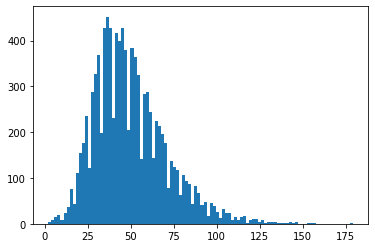

In [ ]:
# Histogram
plt.hist(input_sentence_len, bins=100)

In [ ]:
# Vectorize the data.
# List mask, add padding. two zeros. https://www.tensorflow.org/guide/keras/masking_and_padding
input_token_index = dict([(word, i) for i, word in enumerate(input_characters)])
target_token_index = dict([(word, i) for i, word in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)


for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):

    words = input_text.split(' ')
    for t, word in enumerate(words):
        encoder_input_data[i, t, input_token_index[word]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[""]] = 1.0
    
    words = target_text.split(' ')
    for t, word in enumerate(words):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[word]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[word]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[""]] = 1.0
    decoder_target_data[i, t:, target_token_index[""]] = 1.0

## Build the model


In [ ]:
# 
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)


## Train the model


In [ ]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
history  = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
# Save model
model.save("s2s")


Epoch 1/100
12/12 [==============================] - 38s 3s/step - loss: 2.8008 - accuracy: 0.8505 - val_loss: 0.4967 - val_accuracy: 0.9359
Epoch 2/100
12/12 [==============================] - 33s 3s/step - loss: 0.4480 - accuracy: 0.9370 - val_loss: 0.4158 - val_accuracy: 0.9359
Epoch 3/100
12/12 [==============================] - 32s 3s/step - loss: 0.3911 - accuracy: 0.9404 - val_loss: 0.3930 - val_accuracy: 0.9359
Epoch 4/100
12/12 [==============================] - 32s 3s/step - loss: 0.3647 - accuracy: 0.9418 - val_loss: 0.3774 - val_accuracy: 0.9359
Epoch 5/100
12/12 [==============================] - 33s 3s/step - loss: 0.3477 - accuracy: 0.9412 - val_loss: 0.3696 - val_accuracy: 0.9366
Epoch 6/100
12/12 [==============================] - 32s 3s/step - loss: 0.3365 - accuracy: 0.9415 - val_loss: 0.3571 - val_accuracy: 0.9366
Epoch 7/100
12/12 [==============================] - 33s 3s/step - loss: 0.3271 - accuracy: 0.9432 - val_loss: 0.3553 - val_accuracy: 0.9386
Epoch 8/100
1

INFO:tensorflow:Assets written to: s2s/assets


INFO:tensorflow:Assets written to: s2s/assets


Plot

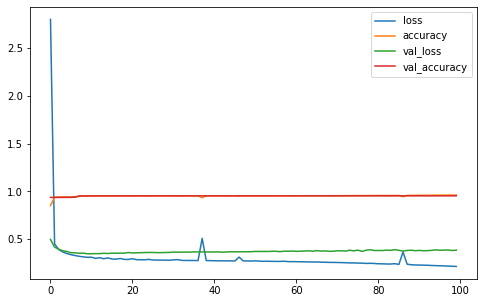

In [ ]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

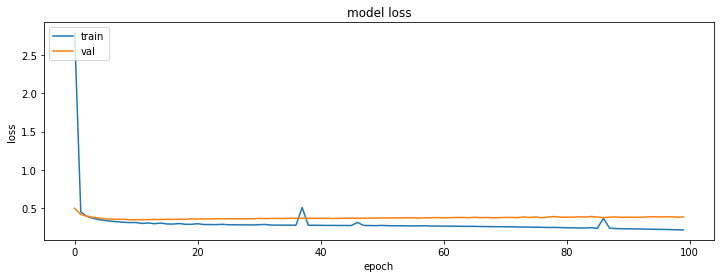

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

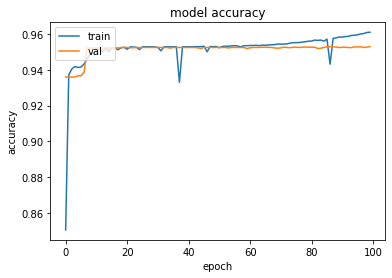

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Run inference (sampling)

1. encode input and retrieve initial decoder state
2. run one step of decoder with this initial state
and a "start of sequence" token as target.
Output will be the next target token.
3. Repeat with the current target token and current states


In [ ]:
target_token_index

{'': 0,
 '</S>': 1,
 '<GLOSS>': 2,
 '<NUM>': 3,
 'AACHEN': 4,
 'AB': 5,
 'ABDECKEN': 6,
 'ABER': 7,
 'ABEREST': 8,
 'ABEZAHLEN': 9,
 'ABFALL': 10,
 'ABFERTIGEN': 11,
 'ABFINDEN': 12,
 'ABHAKEN': 13,
 'ABHAUEN': 14,
 'ABHOLEN': 15,
 'ABHÄNGIG': 16,
 'ABILLIG': 17,
 'ABLAUF': 18,
 'ABLAUFAHREN': 19,
 'ABLAUFEST': 20,
 'ABLAUFZÄHLEN': 21,
 'ABLAUFÜR': 22,
 'ABLENKUNG': 23,
 'ABLESEN': 24,
 'ABM': 25,
 'ABMACHEN': 26,
 'ABMACHENDE': 27,
 'ABMACHENICHT': 28,
 'ABNEHMEN': 29,
 'ABSCHALTEN': 30,
 'ABSCHLEPPEN': 31,
 'ABSCHNITT': 32,
 'ABSICHT': 33,
 'ABWEICHUN': 34,
 'ABWEICHUNG': 35,
 'ABWINKEN': 36,
 'ABWINKENACHSCHLAGEN': 37,
 'ABWINKENAME': 38,
 'ABWINKENASAL': 39,
 'ABWINKENDE': 40,
 'ABWINKENE': 41,
 'ABWINKENEHMEN': 42,
 'ABWINKENEIN': 43,
 'ABWINKENICHT': 44,
 'ABWINKENICHTS': 45,
 'ABWINKENUM': 46,
 'ABWINKENÄHEN': 47,
 'ABWISCHEN': 48,
 'ABWÄRTS': 49,
 'ABWÄRTSTEIGERUNG': 50,
 'ABÖSE': 51,
 'ACH': 52,
 'ACHTUN': 53,
 'ACHTUNG': 54,
 'ACHTUNGEBEN': 55,
 'ADEN': 56,
 'ADER': 57,
 'ADR

In [ ]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("s2s")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index[""]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "</S>" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence



You can now generate decoded sentences as such:


In [ ]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)


-
Input sentence:  <SPOKEN> <PER> stricken malen . </S>
Decoded sentence: <GLOSS>ICHICHICHICH</S>
-
Input sentence:  <SPOKEN> Ja da sieht man es auch . </S>
Decoded sentence: <GLOSS>ICHICHICHICH</S>
-
Input sentence:  <SPOKEN> Der Sportverein umfasst </S>
Decoded sentence: <GLOSS>ICHICHWORTGEHEN</S>
-
Input sentence:  <SPOKEN> Versuchsweise ? </S>
Decoded sentence: <GLOSS>ICHICHICHICH</S>
-
Input sentence:  <SPOKEN> Alle drei Jahre . </S>
Decoded sentence: <GLOSS>ICHICHICHICH</S>
-
Input sentence:  <SPOKEN> Stimmt <NUM> Jahre . </S>
Decoded sentence: <GLOSS>ICHICHICHICH</S>
-
Input sentence:  <SPOKEN> <PER> hat drei Kinder . </S>
Decoded sentence: <GLOSS>ICHICHICHICH</S>
-
Input sentence:  <SPOKEN> Diese drei Flüsse . </S>
Decoded sentence: <GLOSS>ICHICHICHICH</S>
-
Input sentence:  <SPOKEN> Damit wird Schluss sein . </S>
Decoded sentence: <GLOSS>ICHICHICHGEHEN</S>
-
Input sentence:  <SPOKEN> Das war mein Plan . </S>
Decoded sentence: <GLOSS>ICHICHICHICH</S>
-
Input sentence:  <SPOKEN>